In [1]:
# !pip install pymorphy3

import requests
import pymorphy3
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Загрузка текста и сохранение в переменную
url = 'https://raw.githubusercontent.com/nevmenandr/word2vec-russian-novels/master/books_before/MasterAndMargarita.txt'
resp = requests.get(url)
text = resp.text

sents = sent_tokenize(text.lower())  # Приведение текста к нижнему регистру, разбиение на отдельные предложения и сохранение в list

tokenizer = RegexpTokenizer(r'\w+')  # Особенность токенайзера RegexpTokenizer - удаляет из текста все знаки препинания
sents_tokenize = [tokenizer.tokenize(sent) for sent in sents]  # Разбиение каждого предложения на слова

stopwords_ru = stopwords.words('russian')  # Удаление из текста стоп-слов
sents_tokenize = [[word for word in text_cur if word not in stopwords_ru] for text_cur in sents_tokenize]

morph = pymorphy3.MorphAnalyzer()  # Приведение слов к "базовой" форме с использованием pymorphy3
sents_tokenize_morph = [[morph.normal_forms(word)[0] for word in text_cur] for text_cur in sents_tokenize]

In [31]:
# Строительство модели
model = Word2Vec(vector_size = 3, window = 2, min_count = 100)  # Берём слова, встречающиеся больше ста раз
# vector_size - размерность векторов, которые мы хотим обучить
# window - ширина окна контекста
# min_count - если слово встречается реже, для него не учим модель

# Строительство словаря, чтобы обучение шло быстрее
model.build_vocab(sents_tokenize_morph)

# Обучение модели
model.train(sents_tokenize_morph, total_examples = model.corpus_count, epochs = 100)
# Первый аргумент - наша выборка, генератор будет вкидывать в модель наши тексты, пока они не кончатся
# Второй аргумент - число примеров в выборке
# Третий аргумент - количество эпох обучения: сколько раз модель пройдётся по всему корпусу текстов

(455030, 7080900)

In [32]:
# Применение преобразования t-SNE для снижения размерности данных

vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
tsne = TSNE(n_components = 2, early_exaggeration = 30, random_state = 1, n_jobs = -1)
X_tsne = tsne.fit_transform(X)

# Объединение X_tsne и vocab в датафрейм с использованием pandas
df = pd.DataFrame(X_tsne, index = vocab, columns = ['x', 'y'])

In [33]:
# Отрисовка визуализации t-SNE с использованием библиотеки Bokeh
output_notebook()

# Создание графической фигуры
p = figure(tools = "pan, wheel_zoom, reset, save",
           toolbar_location = "above",
           title = "word2vec T-SNE")

source = ColumnDataSource(data = dict(x1 = X_tsne[:, 0],
                                    x2 = X_tsne[:, 1],
                                    names = vocab))

# Добавление маркеров разброса на график
p.scatter(x = "x1", y = "x2", size = 6, source = source)

# Добавление меток на основе данных в ColumnDataSource
labels = LabelSet(x = "x1", y = "x2", text = "names", y_offset = 6,
                  text_font_size = "8pt", text_color = "#555555",
                  source = source, text_align = 'center')
p.add_layout(labels)

show(p)  # Вывод интерактивной визуализации, с возможностью двигать и масштабировать

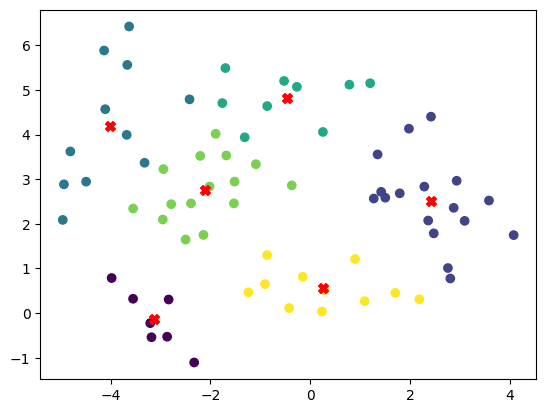

In [35]:
# Инициализация модели K-Means с 6 кластерами
kmeans = KMeans(n_clusters = 6, n_init = 10)

# Обучение модели на данных
kmeans.fit(X_tsne)

# Получение меток кластеров для каждого объекта
labels = kmeans.labels_

# Получение координат центров кластеров
cluster_centers = kmeans.cluster_centers_

# Настройка отображения результатов кластеризации
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = labels, cmap = 'viridis')
plt.scatter(cluster_centers[:, 0],
            cluster_centers[:, 1],
            c = 'red', marker = 'X', s = 50)

plt.show()  # Вывод визуализации с отрисовкой кластеров